# Imports

## Libraries

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3090


In [150]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler,discard_random_labels, remove_duplicates_preserve_order
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import create_image_grid_from_routes, plot_single_image, visualize_static_orbits
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.propagation import jacobi_constant
from orbit_generation.experiment import get_experiment_data
from orbit_generation.evaluation import calculate_distance, orbits_distances, find_nearest_orbits, find_nearest_orbits_batch
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, plot_linear_regression, compute_centroids

In [3]:
import numpy as np
import os

In [4]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Params

In [5]:
# Experiment 116 parameters (try 86)
params=  {
            "data_used": "EM_N_fix_1500",
            "families_to_discard": 30,
            "seq_len": 100,
            "feature_dim": 7,
            "epochs": 50,
            "val_split": 0.05,
            "batch_size": 32,
            "lr": 0.001,
            "model_name": "vae_conv5_legit",
            "latent_dim": 2,
            "max_iter_convergence": 20,
            "input_seq_len_convergence": 1,
            "samples_to_generate": 100,
            "distance_metric": "euclidean",
            "model_kwargs": {
                "dropout_rate": 0.2,
                "beta": 1
            }
}

In [6]:
# 116
# 85
experiment_id = 116

In [7]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "/orbit-generation/experiments"
experiment_folder = os.path.join(experiments_folder, f"experiment_{experiment_id}")
images_folder = os.path.join(experiment_folder, 'images')

In [8]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
full_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_full_latent_space')
discarded_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_discarded_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
full_family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_full_family_centroids')
## Feature Spaces
features_plot_path = os.path.join(images_folder, f'exp{experiment_id}_features')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
full_histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_full_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(experiment_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


## Data

In [9]:
full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
full_data.shape

(45211, 7, 100)

Remove specific families from the training data

In [10]:
full_orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]

experiment_data = get_experiment_data(experiments_folder=experiments_folder, experiment_id=experiment_id)
discarded_family_ids = experiment_data.get('discarded_family_ids', {})  
discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), discarded_family_ids)
discarded_families = get_orbit_classes(discarded_family_ids)[0]
orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]

discarded_families

['S_L4_SP',
 'S_L1_V',
 'S_L1_HS',
 'S_R34',
 'S_L1_L',
 'S_L4_V',
 'S_R23',
 'S_L2_HN',
 'S_R43',
 'S_R32',
 'S_L1_A',
 'S_R21',
 'S_LPOE',
 'S_R13',
 'S_DPO',
 'S_R14',
 'S_L3_HS',
 'S_DS',
 'S_L2_L',
 'S_DRO',
 'S_L5_A',
 'S_L3_HN',
 'S_BS',
 'S_L3_L',
 'S_L5_V',
 'S_R41',
 'S_L4_A',
 'S_L2_HS',
 'S_LPOW',
 'S_BN']

Get Features

In [11]:
family_labels = get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

Scale

In [12]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([11367, 7, 100])

## Model

In [13]:
model = get_model(params)
model.load_state_dict(torch.load(model_save_path, weights_only=True))

<All keys matched successfully>

# Dataset Latent Space

## Calculations

In [14]:
latent_means, latent_log_vars = model.encode(scaled_data)

latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


(11367, 4)

In [15]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

(11367, 2)

In [16]:
features.shape

(11367, 3)

In [17]:
# Scale full data
full_scaled_data = scaler.transform(torch.tensor(full_data, dtype=torch.float32))

# Encode full data
full_latent_means, full_latent_log_vars= model.encode(full_scaled_data)

full_latent_means = full_latent_means.detach().numpy()

# Calculate stdevs
full_latent_stdevs = torch.exp(0.5 * full_latent_log_vars)
full_latent_stdevs = full_latent_stdevs.detach().numpy()
full_latent_stdevs.shape

(45211, 2)

In [18]:
full_family_labels=get_orbit_classes(full_orbits_id_classes)[0]
family_labels_discarded_train = [label if label in discarded_families else 'training' for label in full_family_labels]
family_labels_discarded_train = np.array(family_labels_discarded_train)
family_labels_discarded_train.shape

(45211,)

In [19]:
full_features=full_orbit_df[feature_names].to_numpy()
full_features.shape

(45211, 3)

In [20]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(10, 2)

In [21]:
# Compute centroid labels
unique_classes = remove_duplicates_preserve_order(orbits_id_classes)
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

10

In [22]:
# Compute full data centroid
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([-0.02933262,  0.00016666], dtype=float32)

In [23]:
# Compute centroids
full_centroid_means = compute_centroids(full_latent_means, full_orbits_id_classes, method='mean')
full_centroid_log_vars = compute_centroids(full_latent_log_vars.detach().numpy(), full_orbits_id_classes, method='mean')
full_centroid_stdevs = compute_centroids(full_latent_stdevs, full_orbits_id_classes, method='mean')
full_centroid_stdevs.shape

(40, 2)

In [24]:
# Calculate full centroid labels
full_unique_classes = remove_duplicates_preserve_order(full_orbits_id_classes)
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

In [25]:
families_discarded_train = [label if label in discarded_families else 'training' for label in full_family_names]
families_discarded_train = np.array(families_discarded_train)
discarded_orbit_indices = [i for i in range(len(family_labels_discarded_train)) if family_labels_discarded_train[i] != 'training']
len(families_discarded_train)

40

## Training Dataset

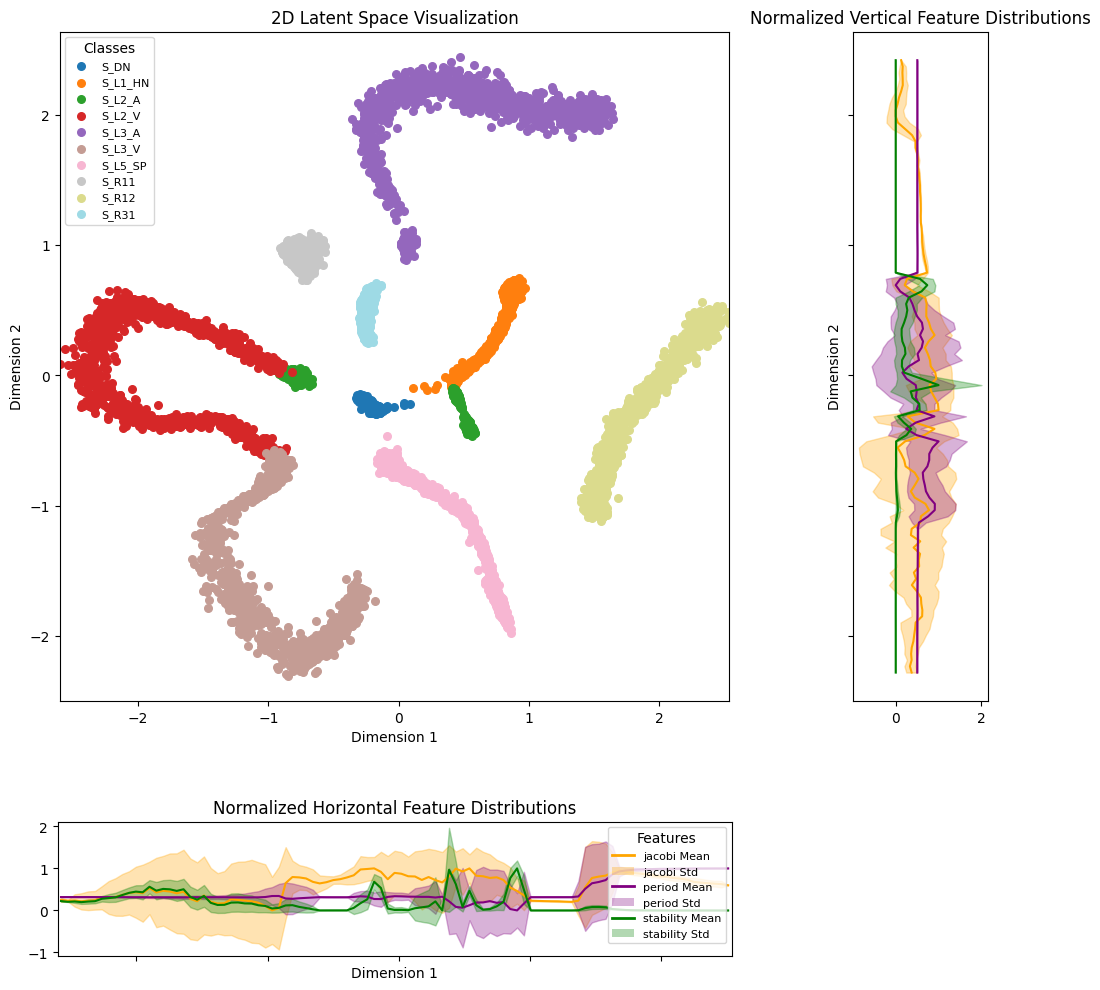

In [26]:
plot_2d_latent_space(latent_means, np.array(family_labels), features=features,
                        feature_names=feature_names,plot_std=True)

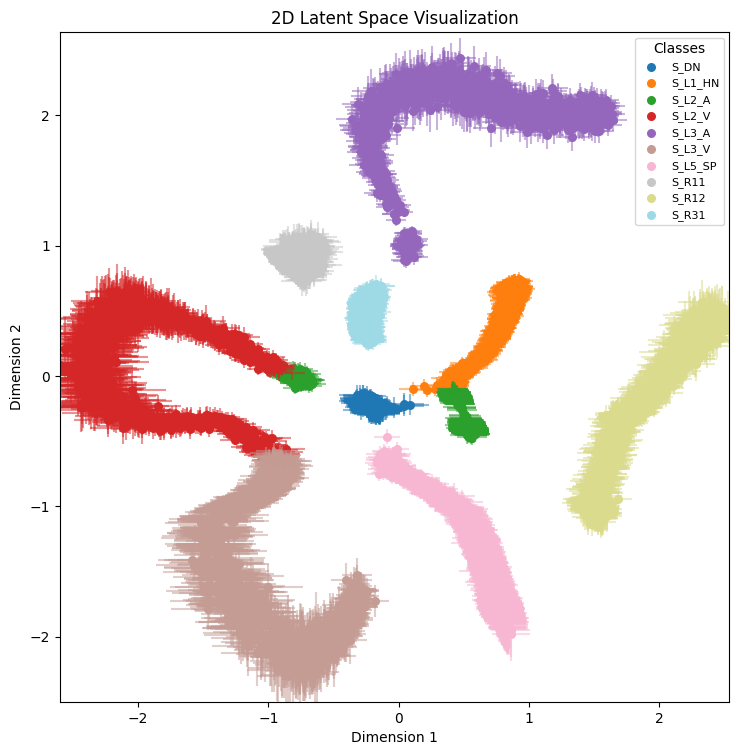

In [27]:
plot_2d_latent_space(latent_means, np.array(family_labels), latent_stdevs=latent_stdevs)

## Full Dataset

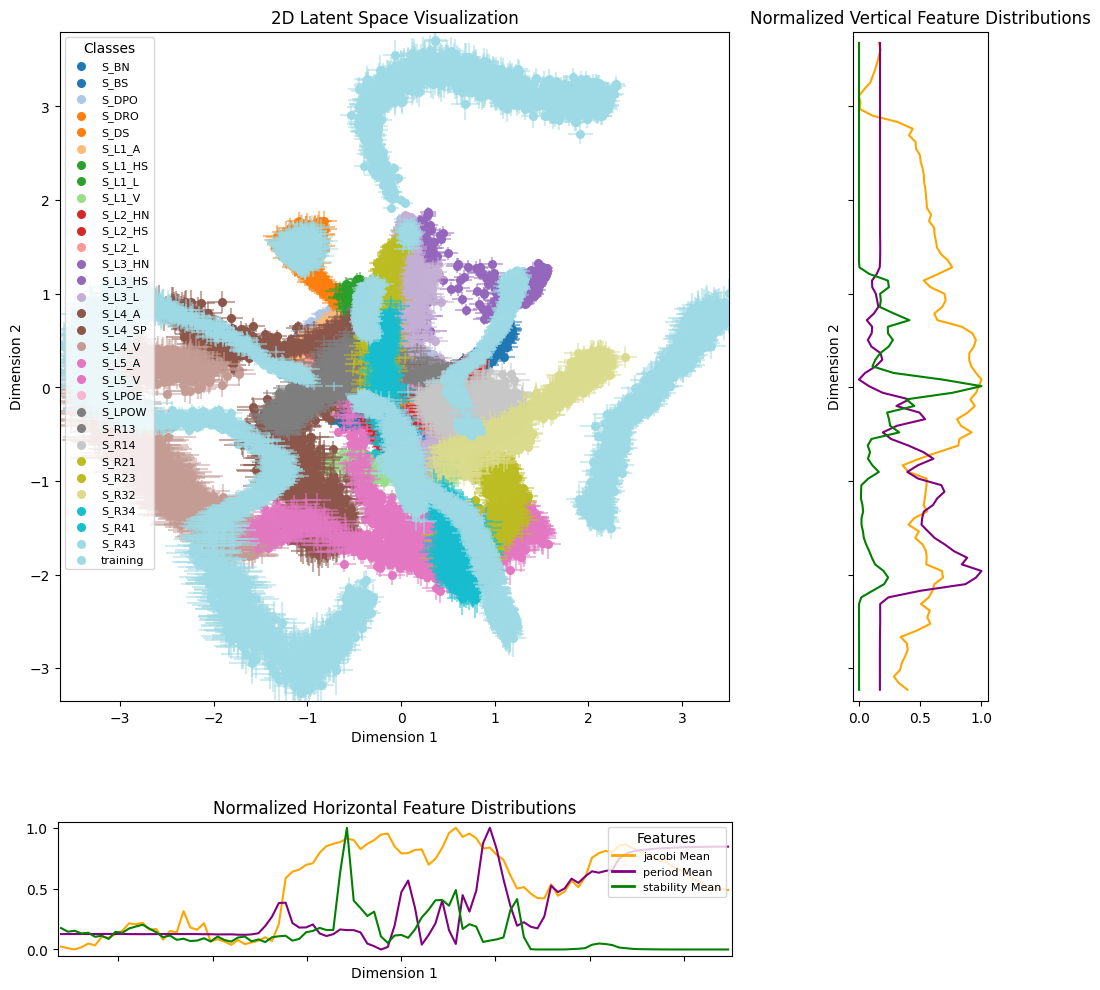

In [28]:
plot_2d_latent_space(full_latent_means, family_labels_discarded_train, features=full_features,
                     feature_names=feature_names, plot_std=False, latent_stdevs=full_latent_stdevs)

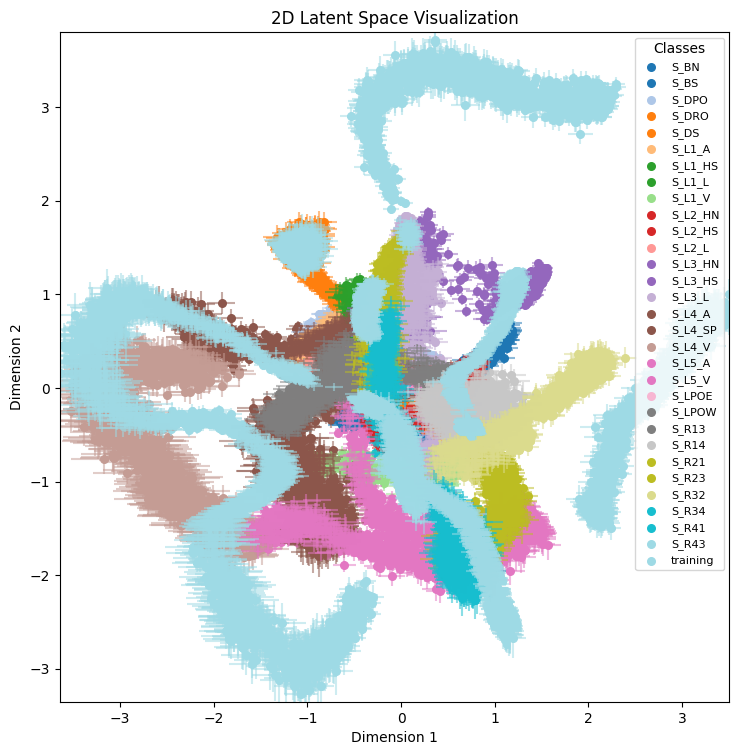

In [29]:
plot_2d_latent_space(full_latent_means, family_labels_discarded_train, latent_stdevs=full_latent_stdevs)

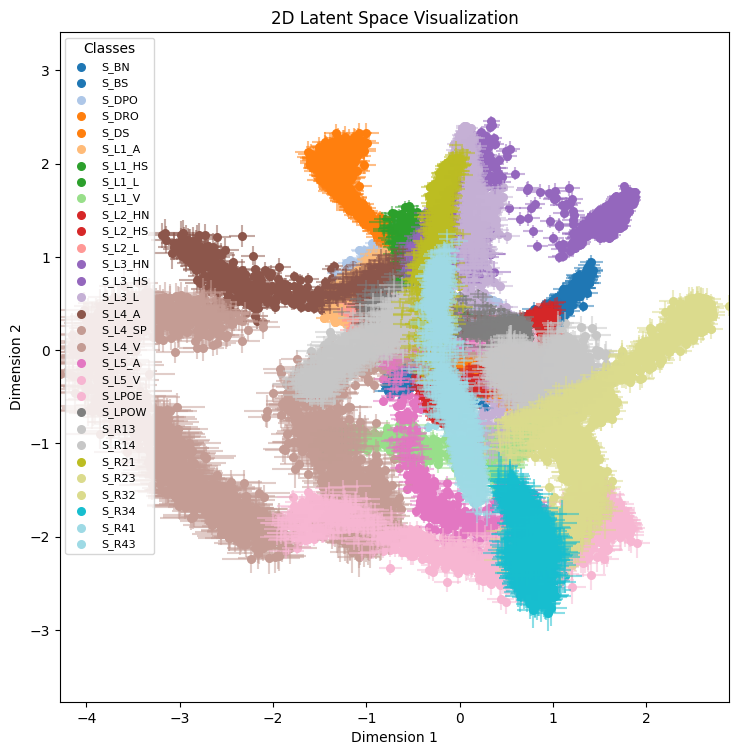

In [30]:
plot_2d_latent_space(full_latent_means[discarded_orbit_indices],
                        family_labels_discarded_train[discarded_orbit_indices],
                        save_path=discarded_latent_space_path,
                        features=full_features[discarded_orbit_indices],
                        latent_stdevs=full_latent_stdevs[discarded_orbit_indices])

## Training Centroids

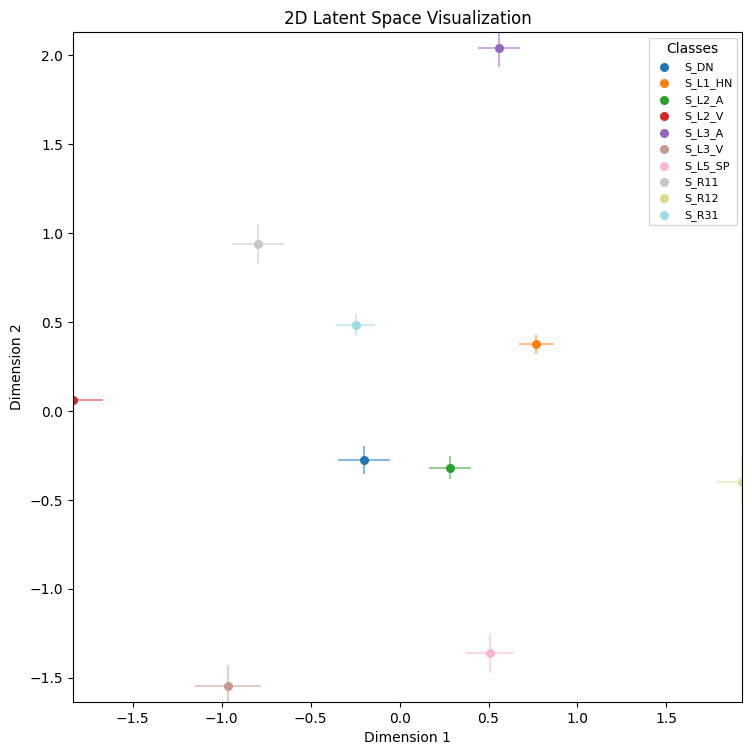

In [31]:
plot_2d_latent_space(centroid_means, np.array(family_names), latent_stdevs=centroid_stdevs)

## Full Centroids

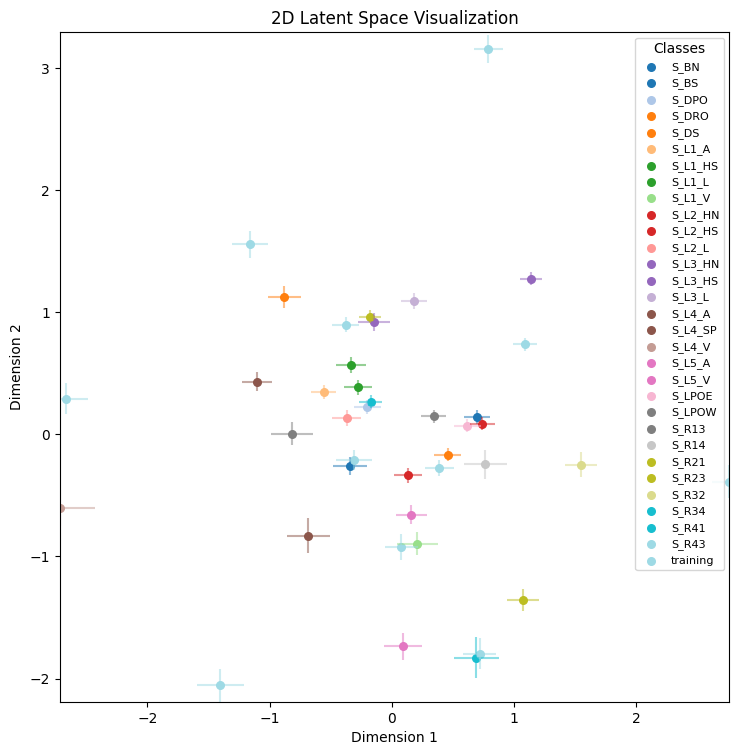

In [32]:
plot_2d_latent_space(full_centroid_means, families_discarded_train, latent_stdevs=full_centroid_stdevs)

# Generation

## Imports

In [33]:
generation = np.load(generated_data_path)
generation.shape

(300, 7, 100)

In [34]:
generation_df = pd.read_csv(generation_df_path)
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.167550        0.356176      2.055638             82.0   
1        0.041144        0.105237      0.053455             98.0   
2        0.073238        0.217751      0.209356            408.0   
3        0.435789        0.365965      0.631862            320.0   
4        0.090326        0.687021      5.928947             54.0   

   correct_order  inversions  kendall_tau_distance  nearest_orbit  \
0           86.0        47.0              0.018990          20235   
1           83.0        59.0              0.023838           2888   
2           65.0       258.0              0.104242           9331   
3           76.0       215.0              0.086869          35789   
4           84.0        32.0              0.012929          40587   

   nearest_orbit_distance  
0                3.617536  
1                2.008097  
2                1.969582  
3               11.514208  
4                2.921422

In [35]:
refined_orbits = np.load(refined_data_path)
reordered_refined_orbits, _, _ = reorder_orbits(refined_orbits)
refined_orbits.shape

(140, 7, 100)

In [36]:
refined_orbits_df = pd.read_csv(refined_orbits_df_path)
refined_orbits_df.head()

id  old_period    period  iterations_convergence         error  \
0   0    5.970095  6.261689                      14  2.177359e-11   
1   1    5.762555  6.747913                      13  1.172315e-12   
2   6    6.125951  6.156255                       7  2.363295e-12   
3   7    4.687366  4.729179                      11  1.505815e-12   
4   9    6.172528  6.571012                       8  2.488562e-13   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0       -1.672384        0.197360       -0.004944       -0.131479   
1        1.146281        0.012663        0.119440        0.007081   
2        1.043744       -0.064992        0.037998       -0.078029   
3        1.097317        0.007104       -0.004319       -0.041922   
4        0.469477       -0.878074       -0.014306       -0.280210   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        2.013470        0.002885     -1.890881     -0.075624  3.156304e-03   
1       -0.226648        0.241234      1.016803      0.004804  2.605369e-01   
2       -0.525581        0.715356      1.081223     -0.016988  2.534353e-02   
3       -0.228566       -0.155920      1.225314     -0.240151  3.673249e-15   
4       -0.131603        0.019204      0.485121     -1.017461 -4.596324e-14   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0     -0.078437      1.672169 -6.984244e-02             94.0           80.0   
1     -0.032308     -0.023131  1.086547e-01            236.0           71.0   
2     -0.064532     -0.580450  8.675794e-01             28.0           87.0   
3     -0.252196     -0.510227  8.882345e-15            486.0           66.0   
4     -0.231256     -0.097450 -7.265335e-13             82.0           82.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        57.0              0.023030               1.519432e-12   
1       158.0              0.063838               2.061160e-12   
2        14.0              0.005657               1.385793e-12   
3       323.0              0.130505               1.739751e-12   
4        55.0              0.022222               3.035552e-12   

   propagated_velocity_error  propagated_energy_error  \
0               5.385060e-12             9.521093e-13   
1               5.886800e-12             8.540419e-14   
2               4.312269e-12             1.557156e-12   
3               3.280340e-12             5.691519e-14   
4               5.311197e-12             4.447172e-14   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.042681           1.845175   
1                       0.022202           2.986561   
2                       0.064102           2.141212   
3                       0.164957           2.886419   
4                       0.014222           2.985590   

   period_distance_with_generation  feature_closest_orbit  \
0                         0.291594                  20211   
1                         0.985357                   1496   
2                         0.030304                  18913   
3                         0.041812                  28511   
4                         0.398484                  29883   

   feature_distance_from_closest_orbit  nearest_orbit  nearest_orbit_distance  \
0                             0.000121          20217                3.169317   
1                             0.011063           2777                3.292461   
2                             0.000408          18915                0.858896   
3                             0.003577          13907                4.619803   
4                             0.000099          29886                0.509034   

   distance_from_generation  centroid_distance  feature_centroid_distance  \
0                  3.986457           1.201150                   1.138238   
1                  3.143534           0.395551                   0.771247   
2                  1.733873           1.764993                   1.

In [37]:
index_100 = refined_orbits_df[refined_orbits_df['id'] >= 100].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 100].empty else None
index_200 = refined_orbits_df[refined_orbits_df['id'] >= 200].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 200].empty else None

In [38]:
orbits_paths = [
    f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_sample1.png',
    f'{experiment_folder}/images/exp{experiment_id}_refined_orbits_sample1.png',
    f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_sample2.png',
    f'{experiment_folder}/images/exp{experiment_id}_refined_orbits_sample2.png',
    f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_sample3.png',
    f'{experiment_folder}/images/exp{experiment_id}_refined_orbits_sample3.png',
]

## Visualization

### Random Sampling

In [39]:
sample1_generation = generation[:100]
sample1_generation.shape

(100, 7, 100)

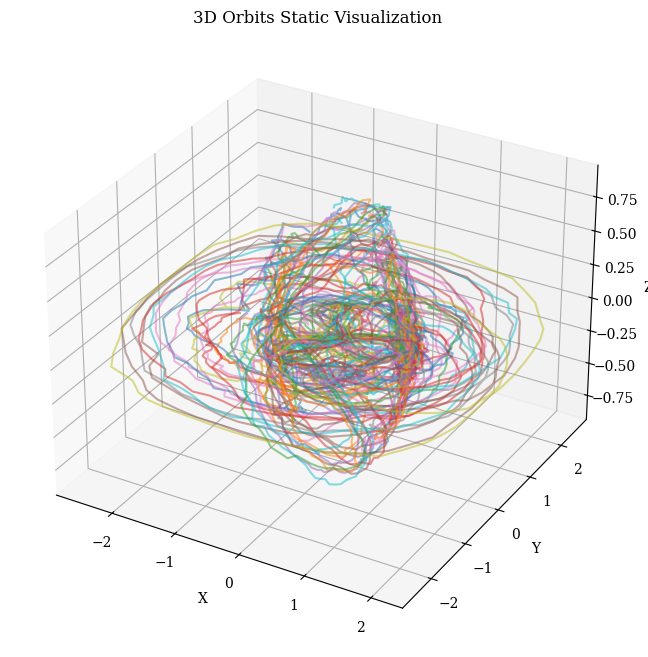

In [40]:
visualize_static_orbits(sample1_generation[:,1:,:], show_legend=False, save_path=orbits_paths[0])

In [41]:
sample1_orbits = reordered_refined_orbits[:index_100,1:,:]
sample1_orbits.shape

(49, 6, 100)

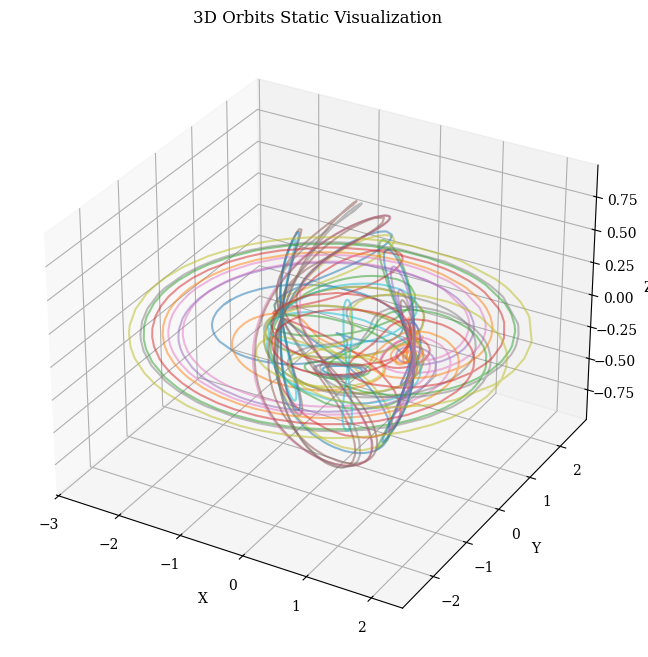

In [42]:
visualize_static_orbits(sample1_orbits, show_legend=False, save_path=orbits_paths[1])

### Grid Sampling

In [43]:
sample2_generation = generation[100:200]
sample2_generation.shape

(100, 7, 100)

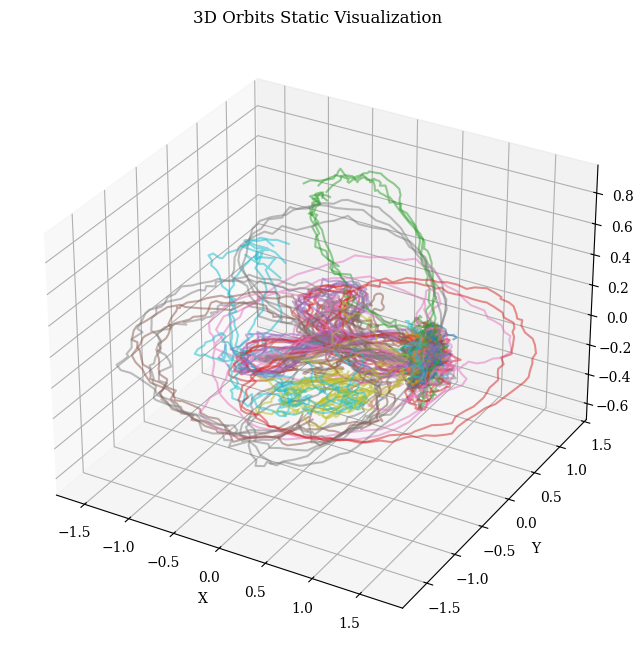

In [44]:
visualize_static_orbits(sample2_generation[:,1:,:], show_legend=False, save_path=orbits_paths[2])

In [45]:
sample2_orbits = reordered_refined_orbits[index_100:index_200,1:,:]
sample2_orbits.shape

(33, 6, 100)

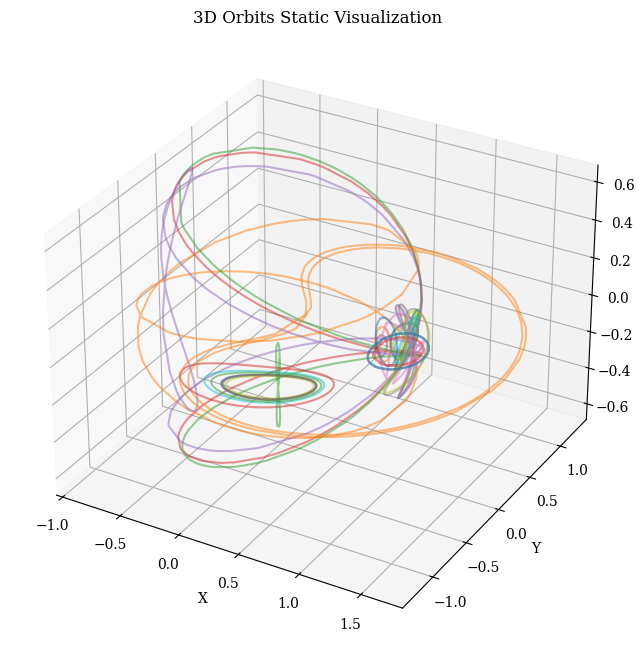

In [46]:
visualize_static_orbits(sample2_orbits, show_legend=False, save_path=orbits_paths[3])

### Centroid Sampling

In [47]:
sample3_generation = generation[200:]
sample3_generation.shape

(100, 7, 100)

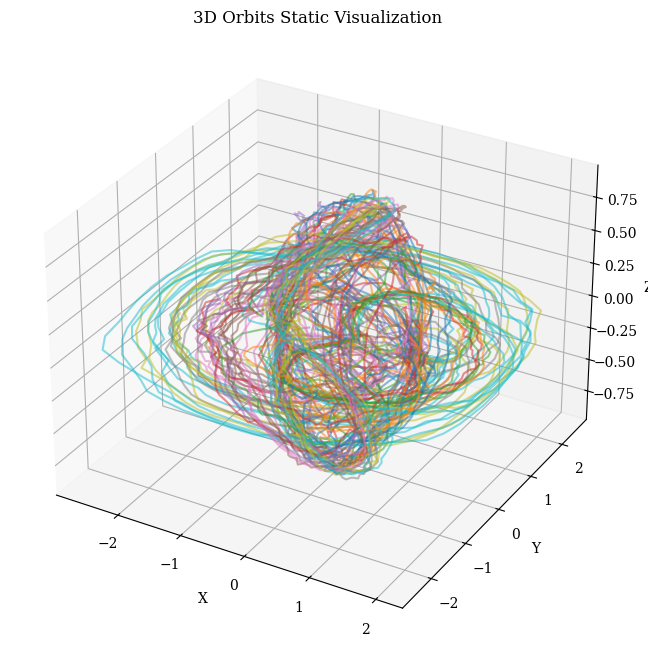

In [48]:
visualize_static_orbits(sample3_generation[:,1:,:], show_legend=False, save_path=orbits_paths[4])

In [49]:
sample3_orbits = reordered_refined_orbits[index_200:,1:,:]
sample3_orbits.shape

(58, 6, 100)

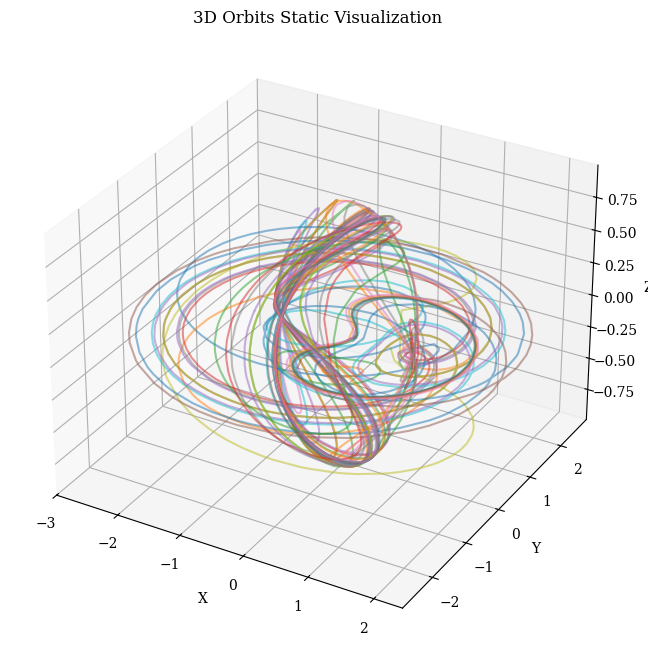

In [50]:
visualize_static_orbits(sample3_orbits, show_legend=False, save_path=orbits_paths[5])

### All Orbits

In [51]:
label_images = [
    'Random Sample Generation (n=100)',
    f'Random Sample Refinement (n={sample1_orbits.shape[0]})',
    'Grid Sample Generation (n=100)',
    f'Grid Sample Refinement (n={sample2_orbits.shape[0]})',
    'Discarded Centroid Sample Generation (n=100)',
    f'Discarded Centroid Sample Refinement (n={sample3_orbits.shape[0]})'
]

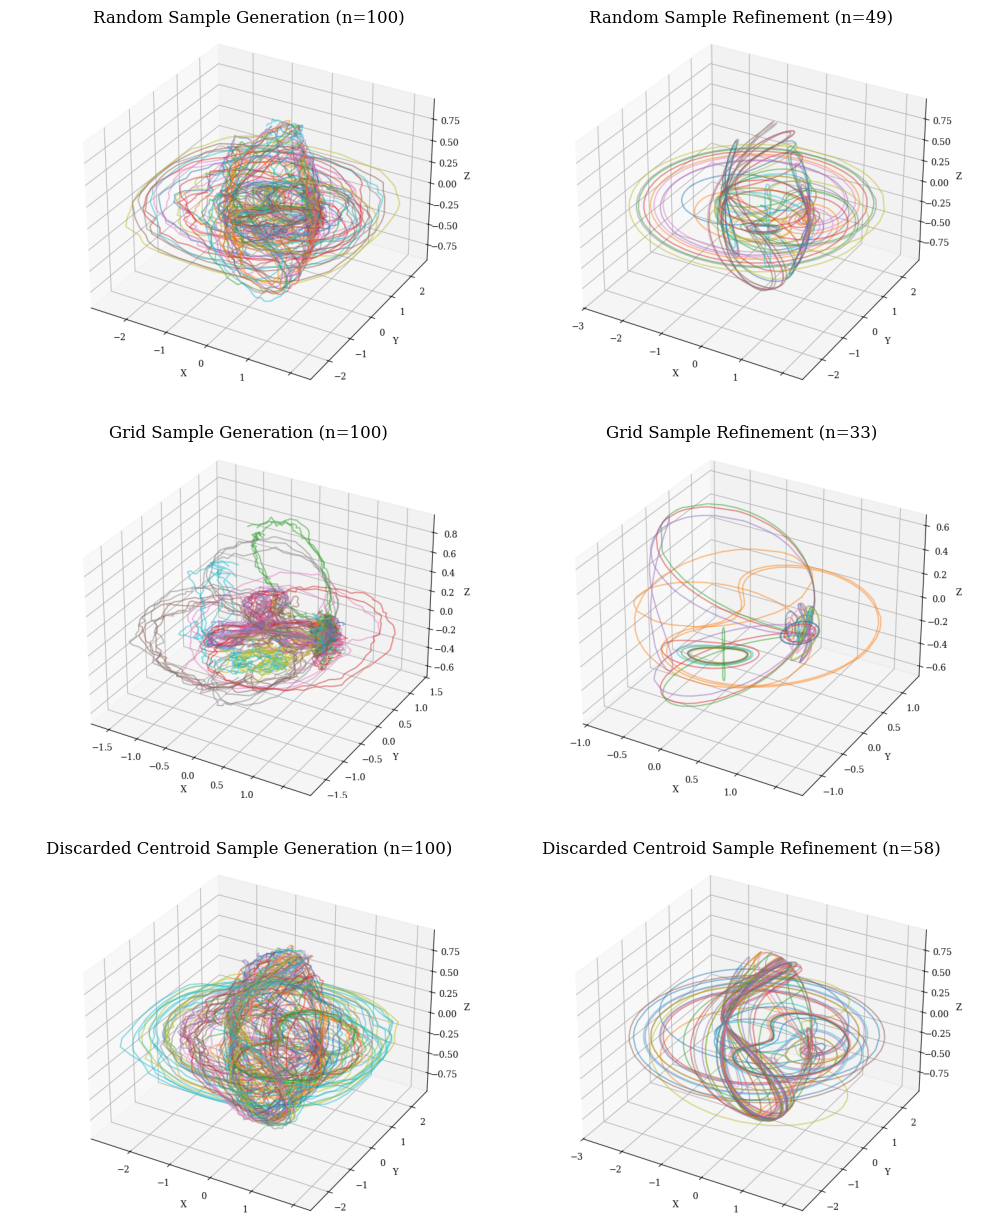

In [52]:
create_image_grid_from_routes(orbits_paths, crop_length=123, hspace=-0.35, label_images=label_images)

In [53]:
orbits_paths_2 = [f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_that_converged.png',
                f'{experiment_folder}/images/exp{experiment_id}_refined_orbits.png']

label_images_2 = ['Generated Orbits that Converged', 'All Converged Orbits']

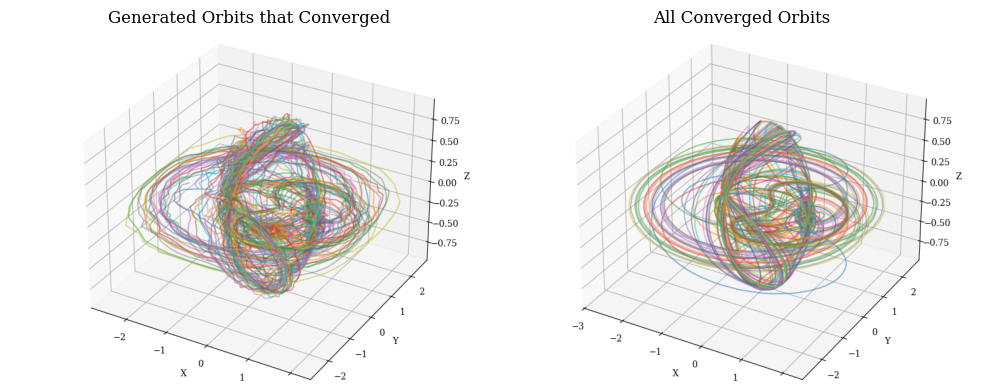

In [54]:
create_image_grid_from_routes(orbits_paths_2, crop_length=123, hspace=0.2, label_images=label_images_2, grid_size=(1,2))

# Latent Space

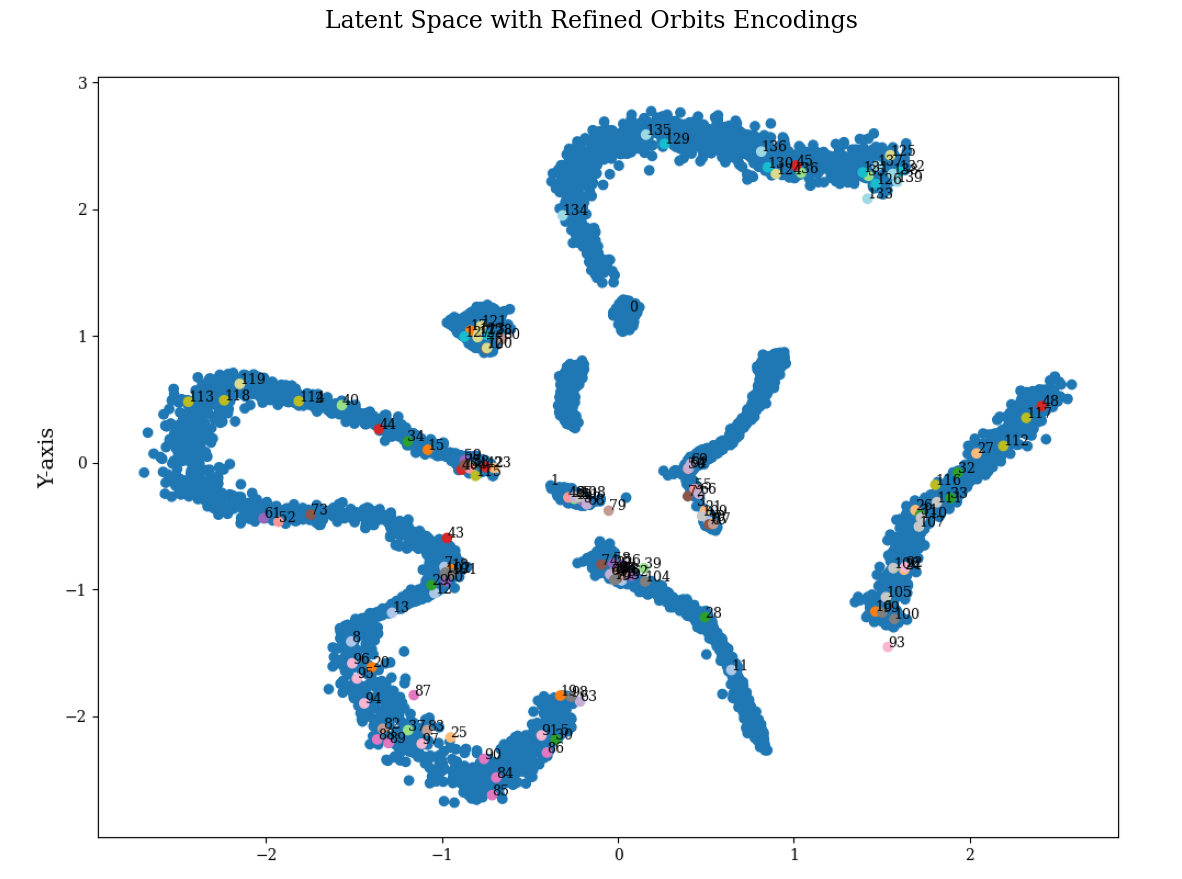

In [55]:
ls_path = f'{experiment_folder}/images/exp{experiment_id}_combined_latent_space.png'
plot_single_image(ls_path, crop_length=70, title='Latent Space with Refined Orbits Encodings')

## Feature Space

In [56]:
results = np.array([jacobi_constant(np.transpose(full_data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
full_orbit_df['calculated_jacobi'] = results

features_used = ['period', 'calculated_jacobi']

dataset_features = full_orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values
refined_orbits_features.shape

(140, 2)

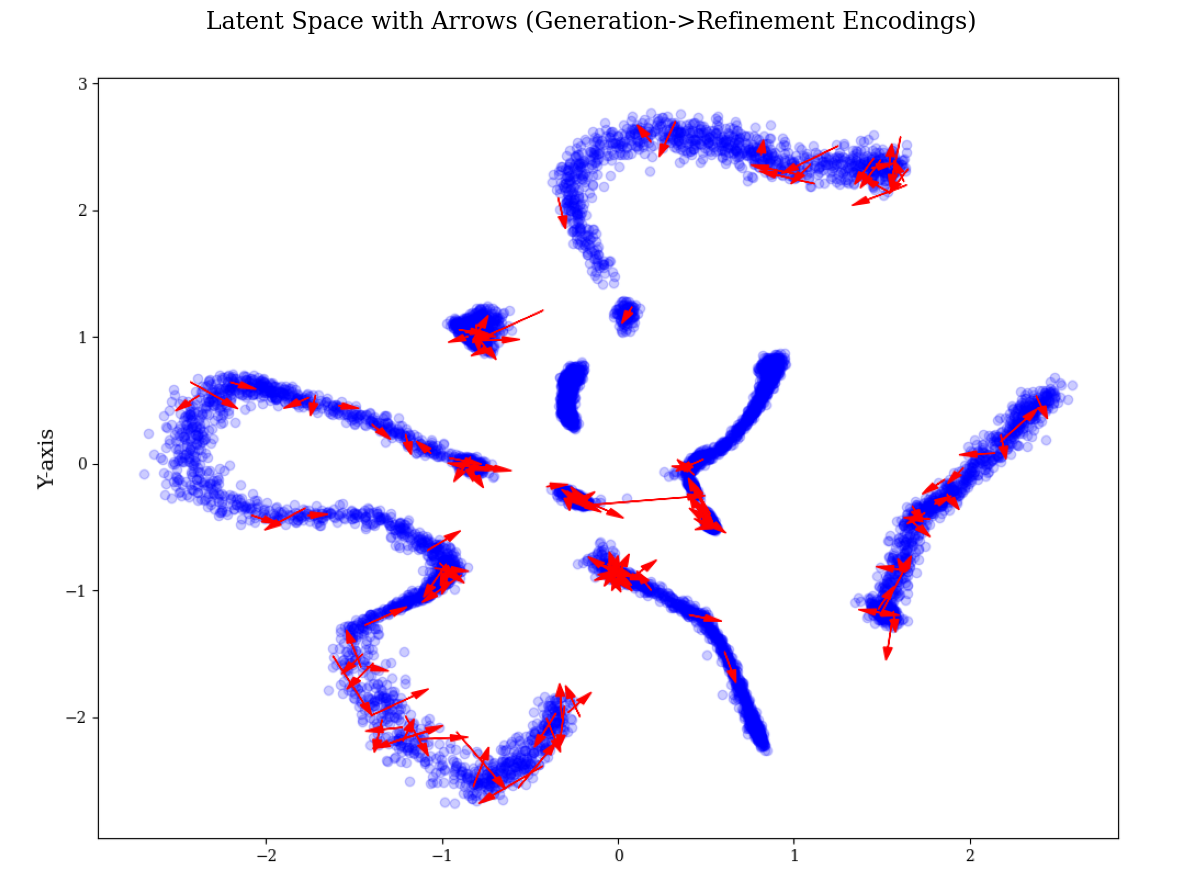

In [57]:
ls_arrows_path = f'{images_folder}/exp{experiment_id}_combined_latent_space_arrows.png'
plot_single_image(ls_arrows_path, crop_length=70, title='Latent Space with Arrows (Generation->Refinement Encodings)')

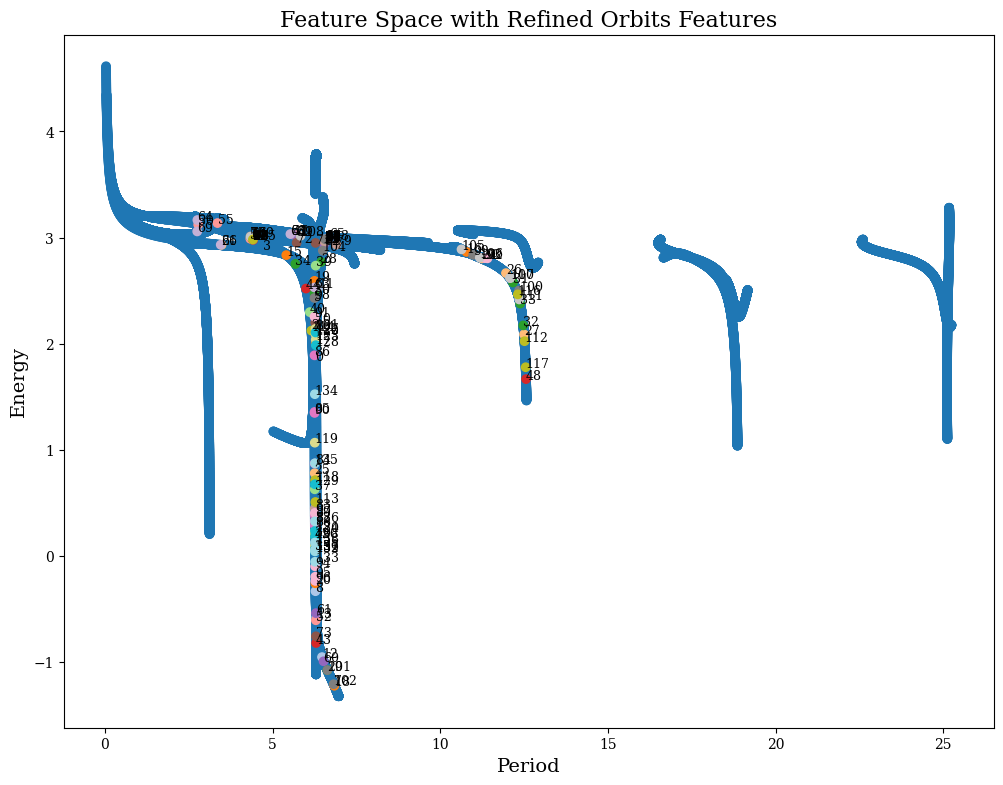

In [58]:
plot_combined_2d_latent_space(dataset_features, refined_orbits_features, title= 'Feature Space with Refined Orbits Features',
                              synthetic_labels=list(range(0, len(refined_orbits_df))),
                              annotation_mode='numbers', axis_labels=('Period', 'Energy'))

# Regression

In [59]:
latent_means.shape

(11367, 2)

In [60]:
latent_stdevs.shape

(11367, 2)

In [61]:
features.shape

(11367, 3)

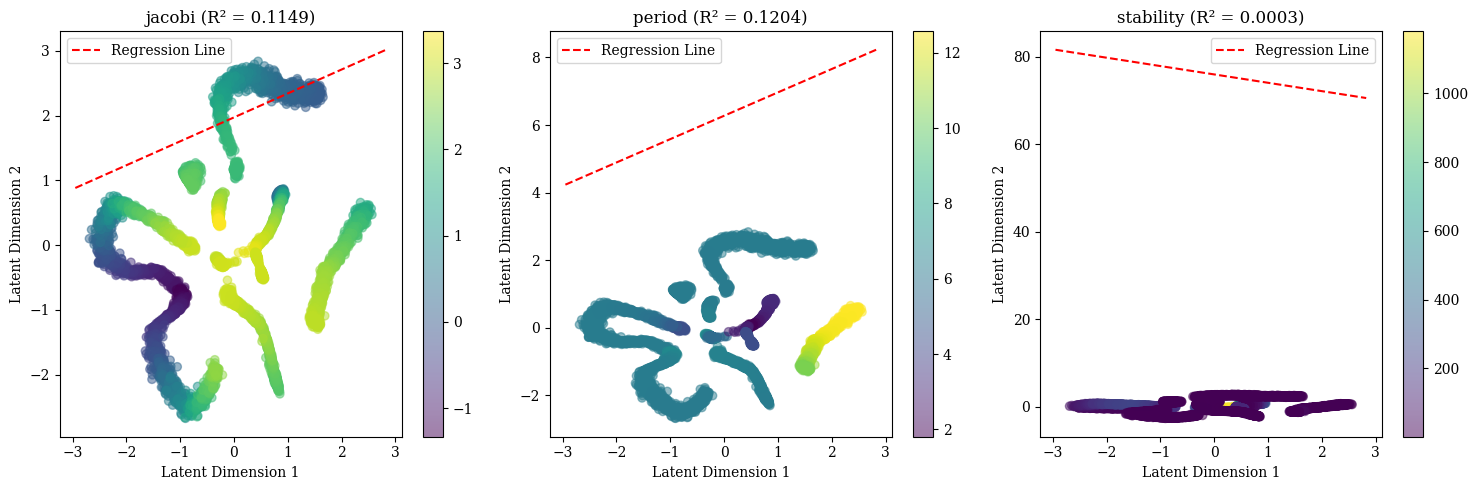

({'jacobi': {'coefficients': array([ 0.36974886, -0.1571682 ], dtype=float32), 'intercept': np.float32(1.9711965), 'r_squared': 0.11489090293085025}, 'period': {'coefficients': array([ 0.6913555 , -0.22356115], dtype=float32), 'intercept': np.float32(6.2745323), 'r_squared': 0.12042282161999451}, 'stability': {'coefficients': array([-1.9110078 ,  0.39902714], dtype=float32), 'intercept': np.float32(75.91551), 'r_squared': 0.00028863026586523066}}, {'regression_jacobi_r2': 0.11489090293085025, 'regression_period_r2': 0.12042282161999451, 'regression_stability_r2': 0.00028863026586523066})


In [62]:
results = plot_linear_regression(latent_means, features, feature_names)
print(results)

# Discovery

## Calculations

In [63]:
filter_condition = refined_orbits_df[['family_of_feature_closest_orbit', 'family_of_closest_orbit']].isin(discarded_family_ids).any(axis=1)
discovery_df = refined_orbits_df[filter_condition]
discovery_df.shape

(30, 43)

In [64]:
discovery_df.head()

id  old_period    period  iterations_convergence         error  \
1    1    5.762555  6.747913                      13  1.172315e-12   
3    7    4.687366  4.729179                      11  1.505815e-12   
9   16    6.528803  6.570699                      10  3.835939e-14   
11  21    6.023031  6.371288                      13  1.399211e-10   
14  29    6.610111  6.561818                       9  2.261375e-13   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
1         1.146281        0.012663        0.119440        0.007081   
3         1.097317        0.007104       -0.004319       -0.041922   
9         0.427496       -0.936014       -0.004755       -0.315845   
11        0.179075       -1.428248        0.013620       -0.977275   
14        0.359305       -0.840463        0.004484       -0.332252   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
1        -0.226648        0.241234      1.016803      0.004804  2.605369e-01   
3        -0.228566       -0.155920      1.225314     -0.240151  3.673249e-15   
9         0.101363       -0.027506      0.497595     -1.013998 -1.657932e-14   
11       -0.185913       -0.006427      0.427502     -1.528860  8.835852e-12   
14        0.031686        0.005566      0.530488     -1.047181  3.333963e-14   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
1      -0.032308     -0.023131  1.086547e-01            236.0           71.0   
3      -0.252196     -0.510227  8.882345e-15            486.0           66.0   
9      -0.231612     -0.106625 -1.248178e-14            266.0           75.0   
11     -1.012535     -0.485334  5.527849e-12            226.0           72.0   
14     -0.294212     -0.161974  7.351506e-15            106.0           80.0   

    inversions  kendall_tau_distance  propagated_position_error  \
1        158.0              0.063838               2.061160e-12   
3        323.0              0.130505               1.739751e-12   
9        188.0              0.075960               2.894810e-12   
11       143.0              0.057778               2.659393e-12   
14        66.0              0.026667               3.166916e-12   

    propagated_velocity_error  propagated_energy_error  \
1                5.886800e-12             8.540419e-14   
3                3.280340e-12             5.691519e-14   
9                4.941286e-12             3.018909e-15   
11               5.263543e-12             3.917585e-12   
14               5.623738e-12             5.539901e-15   

    latent_distance_to_generation  calculated_jacobi  \
1                        0.022202           2.986561   
3                        0.164957           2.886419   
9                        0.082064           2.985193   
11                       0.152612           2.528259   
14                       0.107038           2.973616   

    period_distance_with_generation  feature_closest_orbit  \
1                          0.985357                   1496   
3                          0.041812                  28511   
9                          0.041896                  26691   
11                         0.348258                  26180   
14                         0.048293                  26656   

    feature_distance_from_closest_orbit  nearest_orbit  \
1                              0.011063           2777   
3                              0.003577          13907   
9                              0.000118          29885   
11                             0.000533          29396   
14                             0.000131          29845   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
1                 3.292461                  3.143534           0.395551   
3                 4.619803                  4.623523           0.586623   
9                 0.928135                  1.814572           0.927912   
11                4.343660                  3.749823           1.767455   
14            

In [65]:
# Stack discovered orbits with their feature closest and nearest orbits
refinement_indexes = discovery_df.index.to_list()
feature_closest_orbit_indexes = discovery_df['feature_closest_orbit'].to_list()
nearest_orbit_indexes = discovery_df['nearest_orbit'].to_list()

discovery_refinement = reordered_refined_orbits[refinement_indexes]
feature_closest_orbits = full_data[feature_closest_orbit_indexes]
nearest_orbits = full_data[nearest_orbit_indexes]

refinement_and_closers = np.stack(
    (discovery_refinement, feature_closest_orbits, nearest_orbits),
    axis=1
)
refinement_and_closers.shape

(30, 3, 7, 100)

## Test on distance

Feature Closest Distance

In [204]:
# Get one orbit and its feature closest
random_orbit_index = 3
f1 = refined_orbits_features[random_orbit_index]
orbit_index = int(refined_orbits_df.iloc[3]['feature_closest_orbit'])
f2 = dataset_features[orbit_index]

In [205]:
refined_orbits_df['feature_distance_from_closest_orbit'].iloc[random_orbit_index]

np.float64(0.00357744595278)

In [206]:
calculate_distance(f1, f2)

np.float64(0.0035774459527800864)

Spatial Closest distance

In [207]:
# Get one orbit and its feature closest
random_orbit_index = 3
orbit_index = int(refined_orbits_df.iloc[random_orbit_index]['nearest_orbit'])

In [208]:
refined_orbits_df['nearest_orbit_distance'].iloc[random_orbit_index]

np.float64(4.619802818897431)

In [209]:
orbits_distances(refined_orbits[random_orbit_index:random_orbit_index+1,1:], full_data[orbit_index:orbit_index+1,1:], distance_metric='euclidean')

array([4.61980282])

## Full Visualization

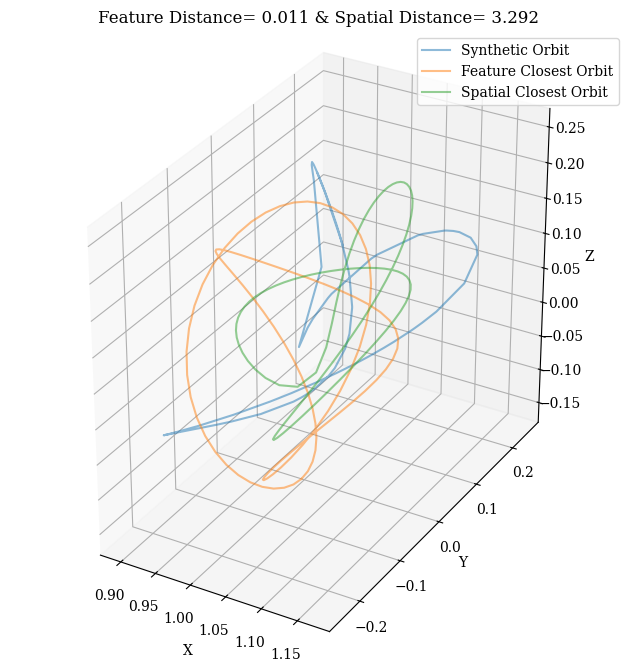

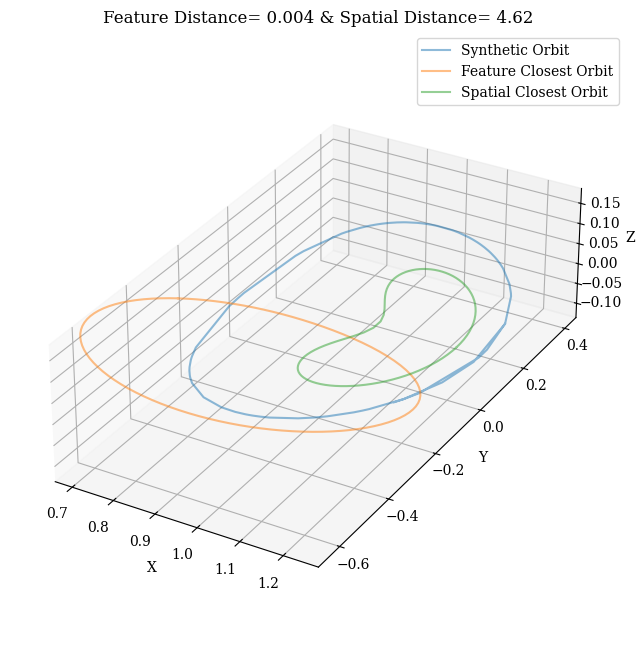

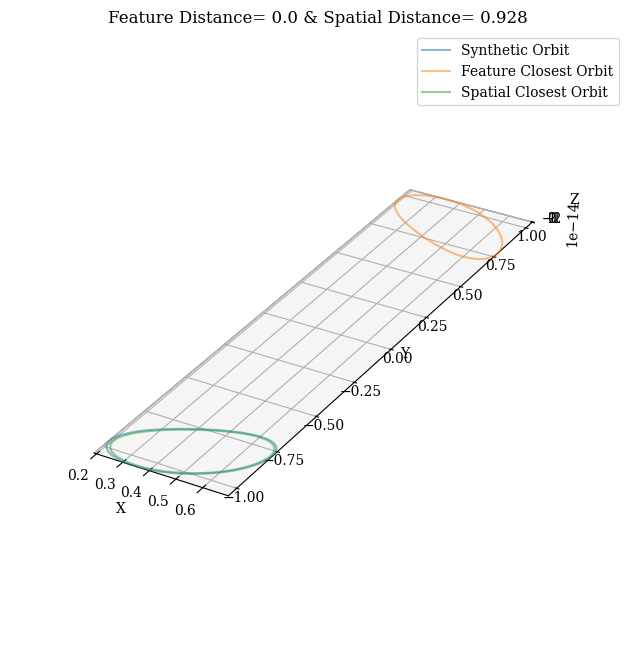

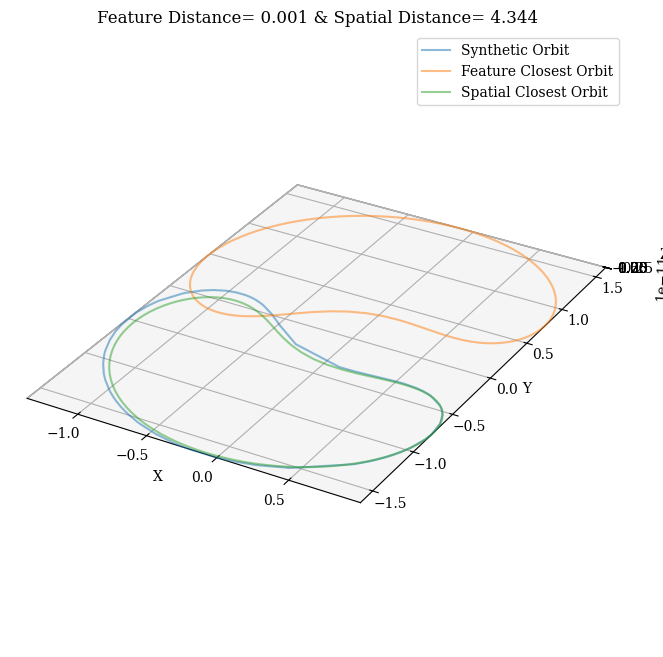

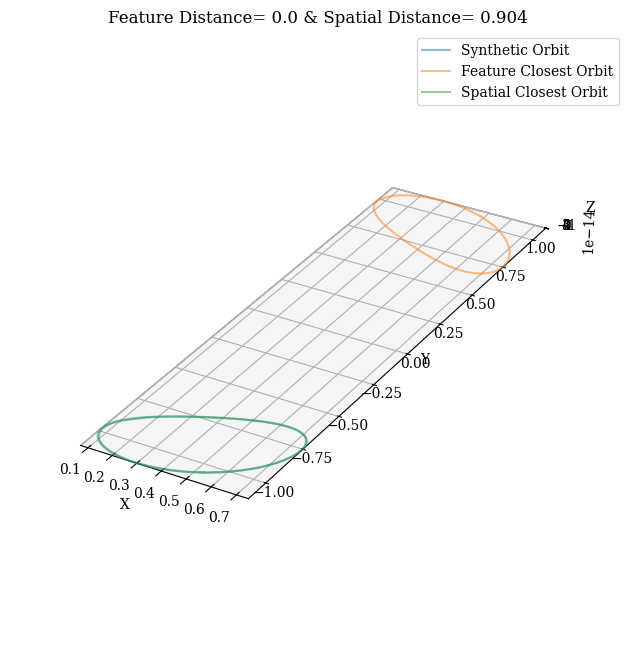

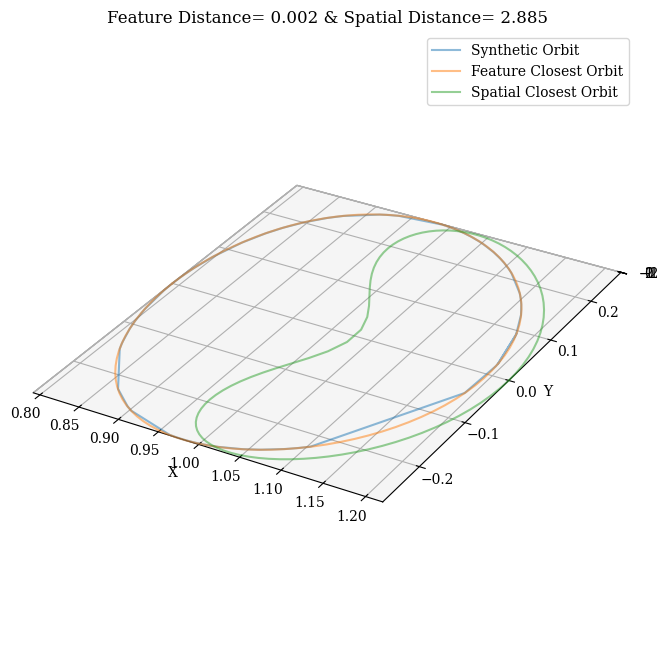

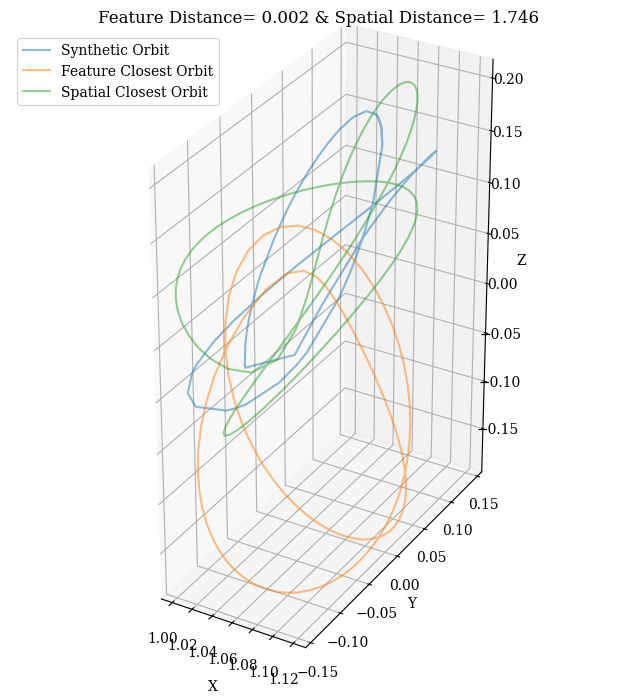

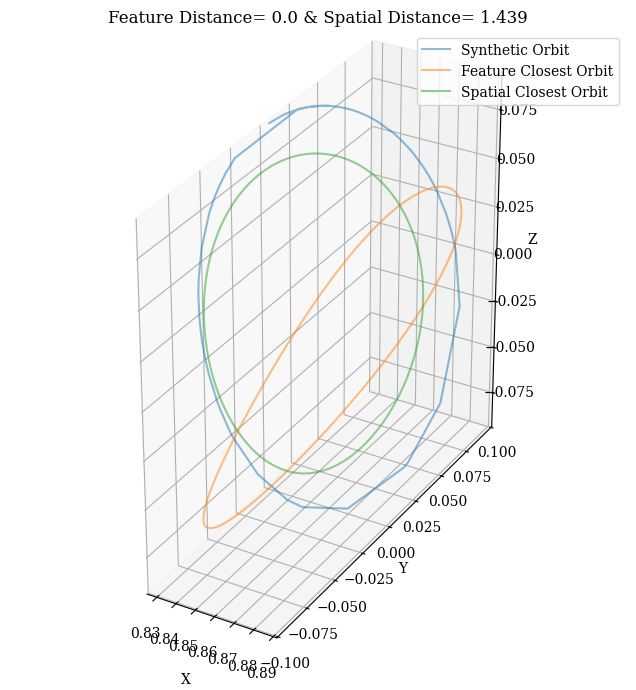

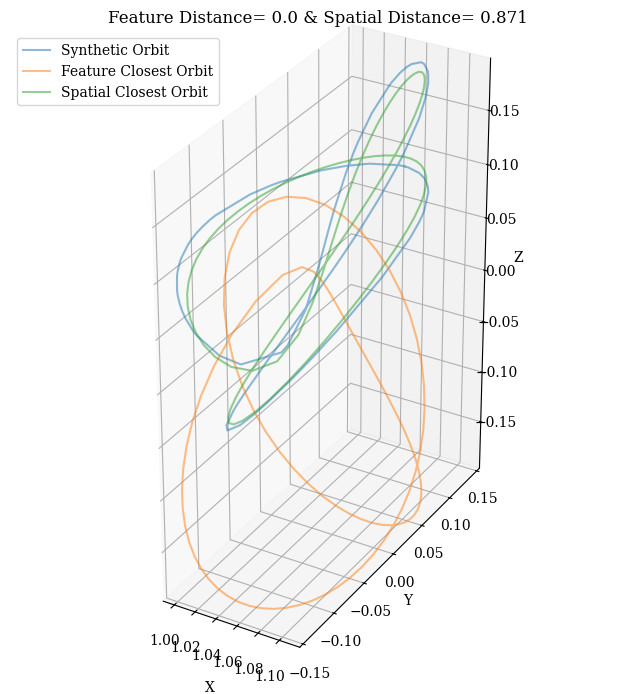

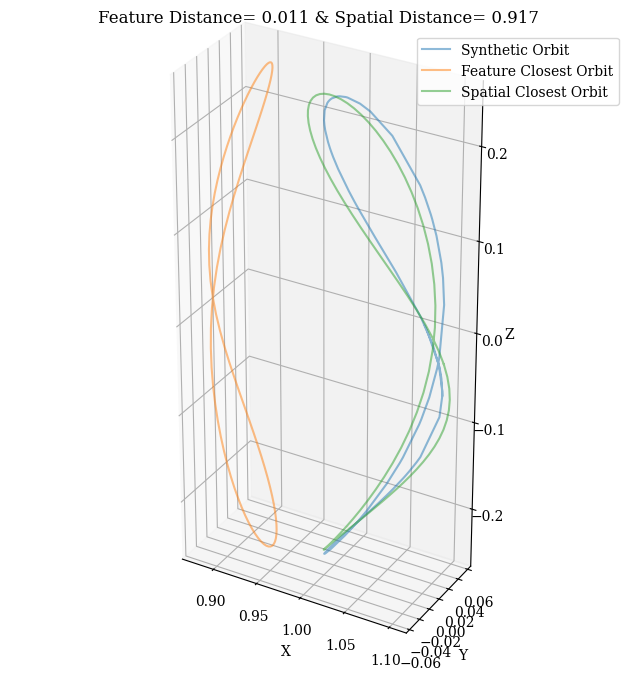

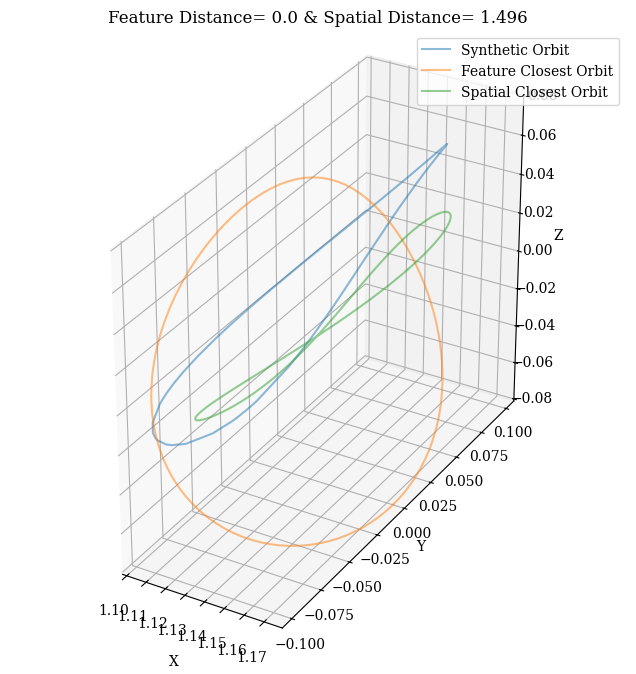

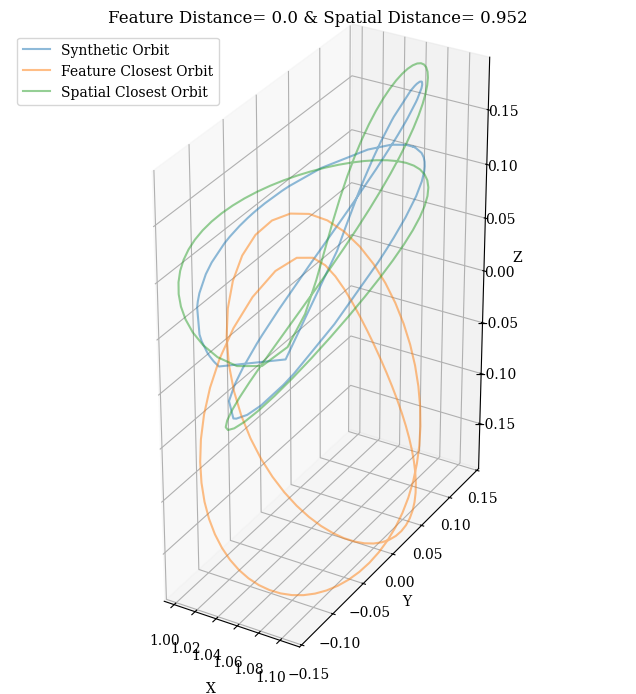

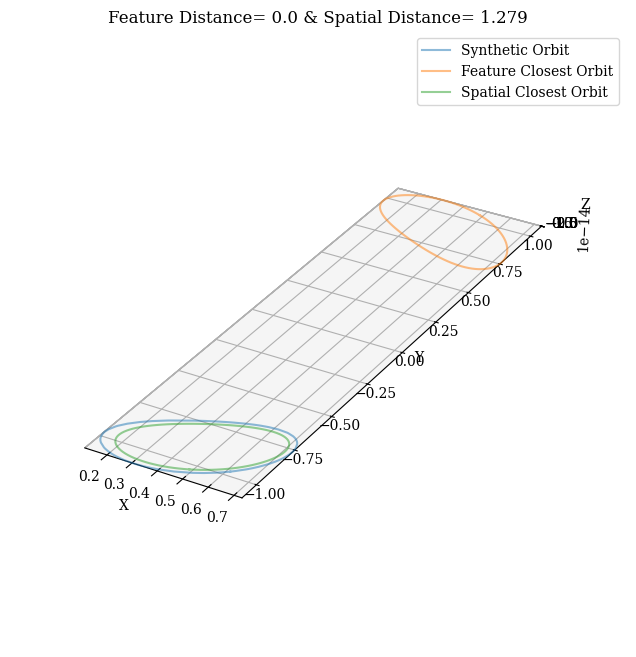

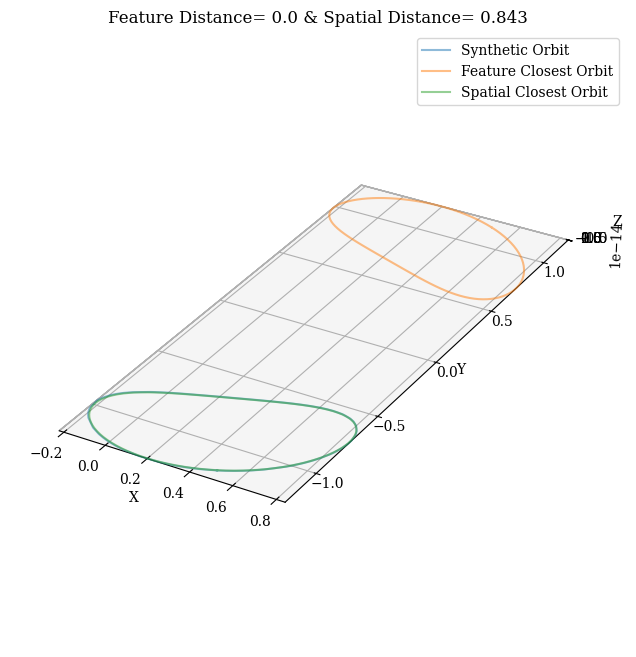

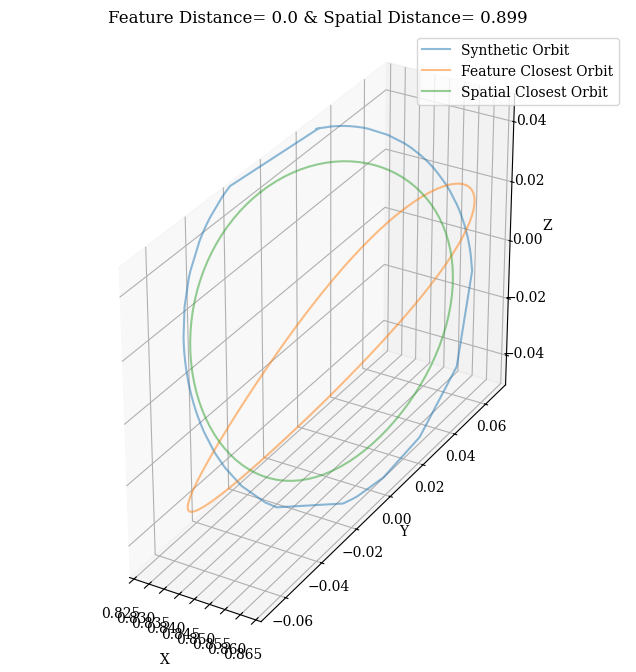

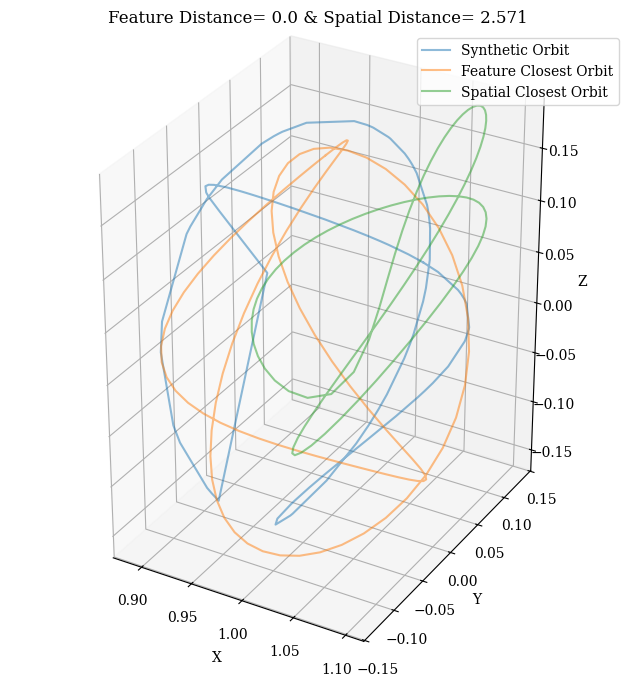

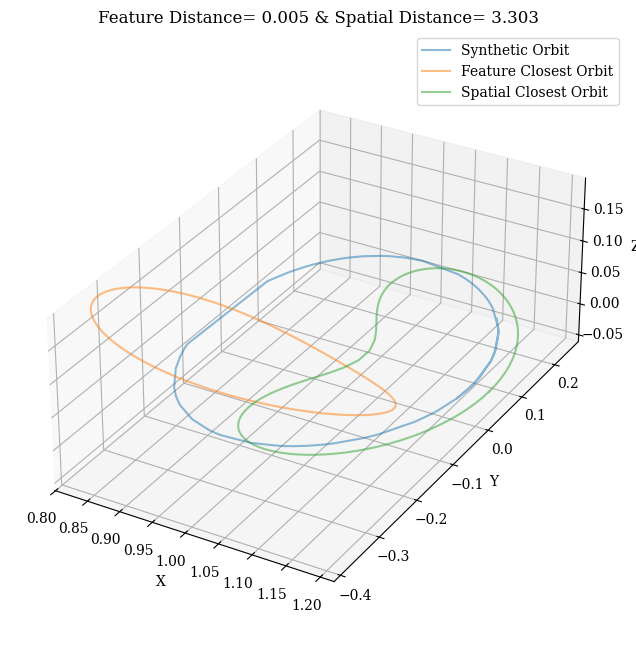

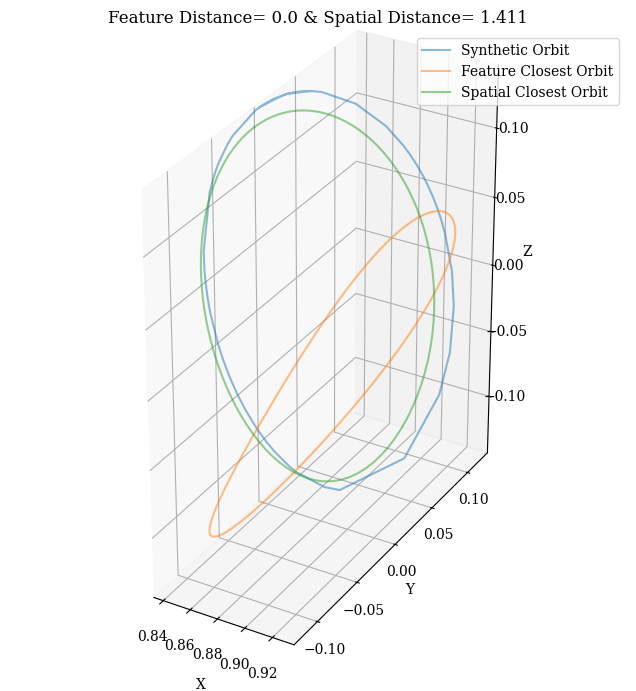

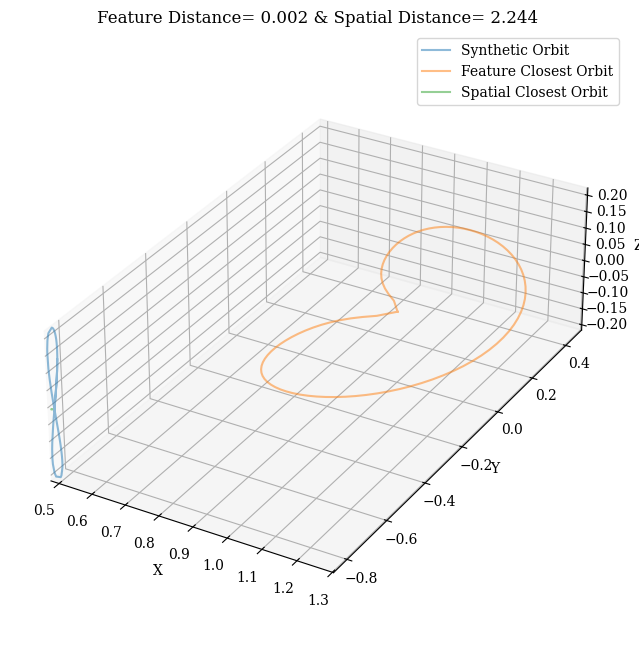

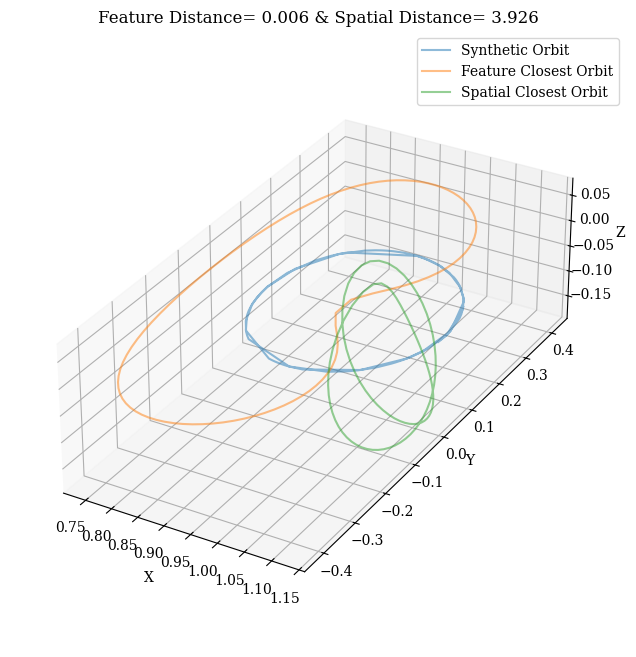

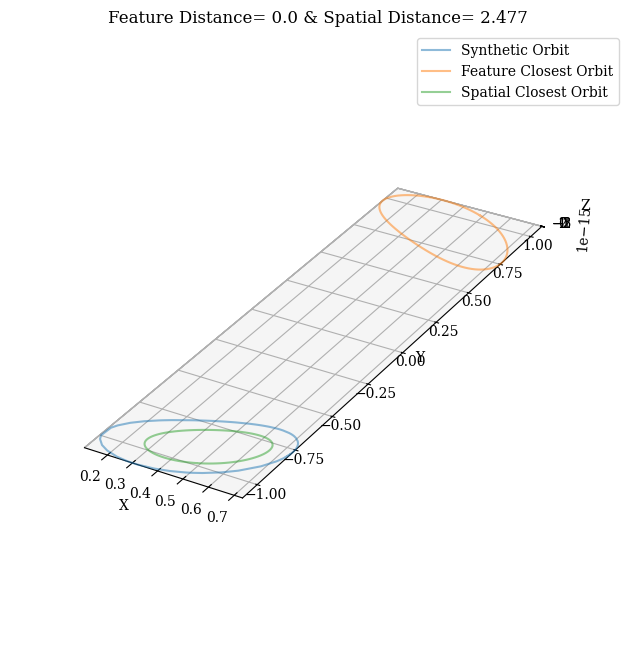

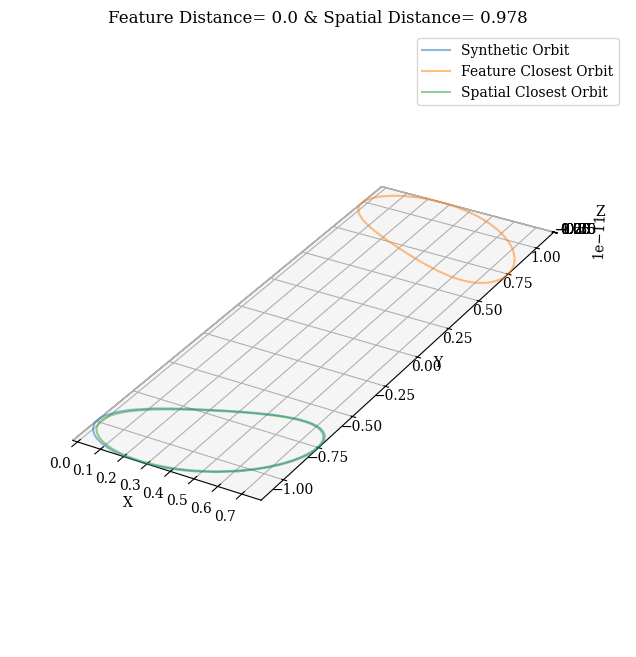

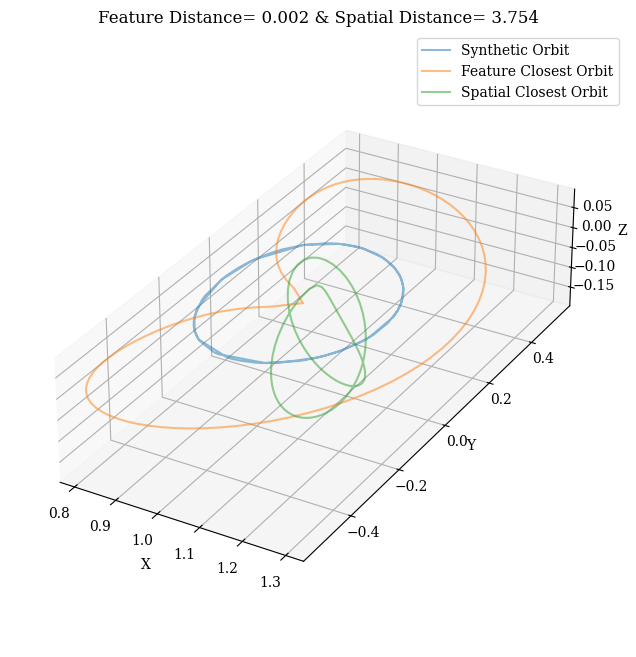

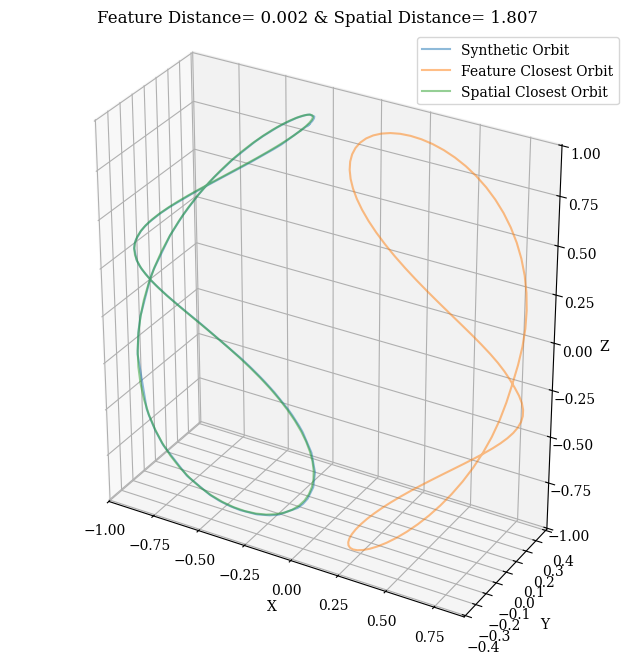

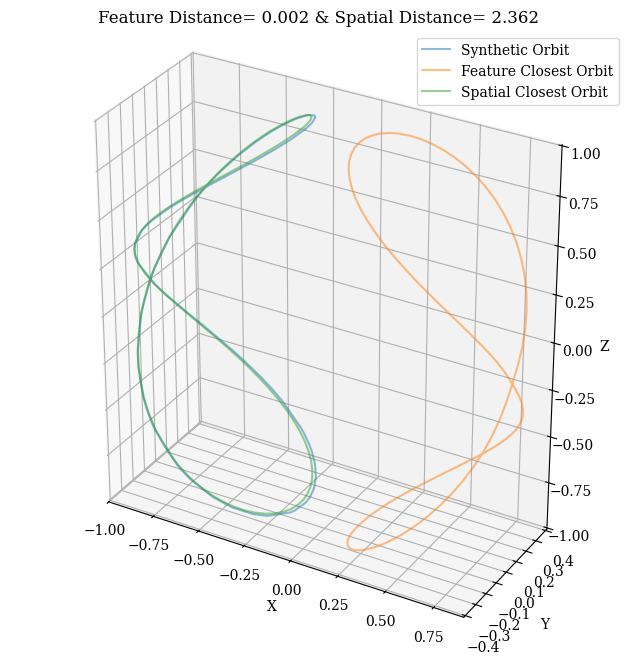

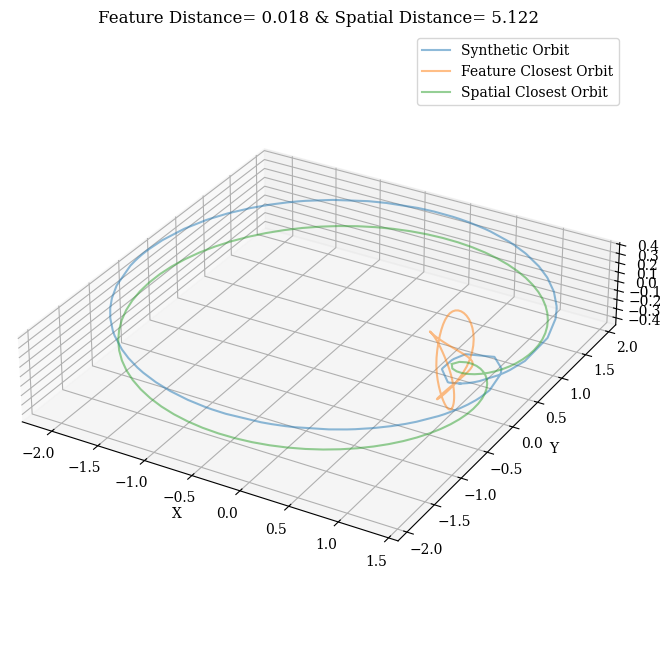

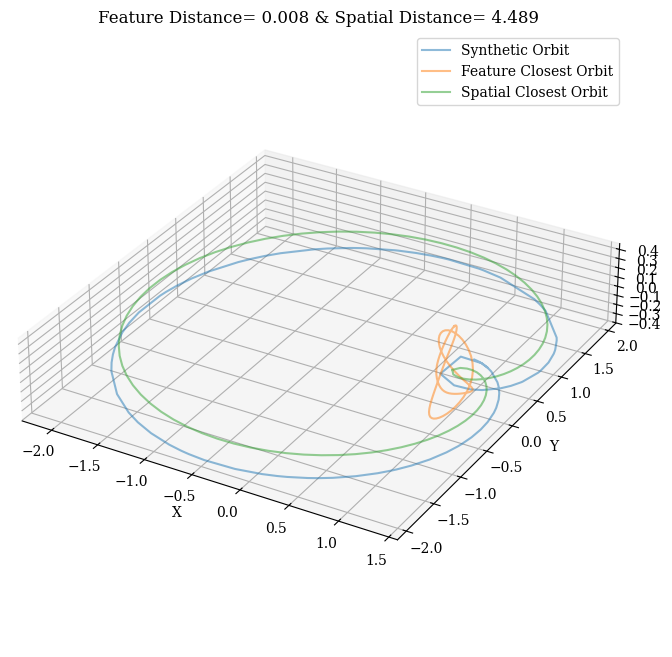

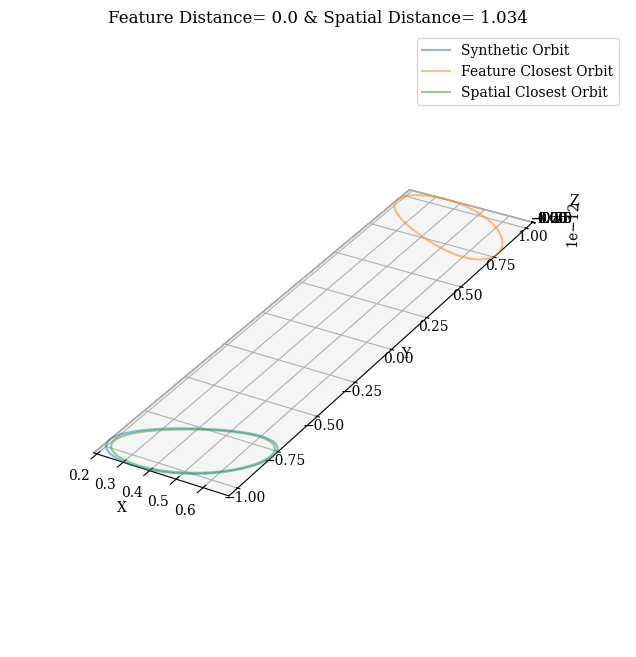

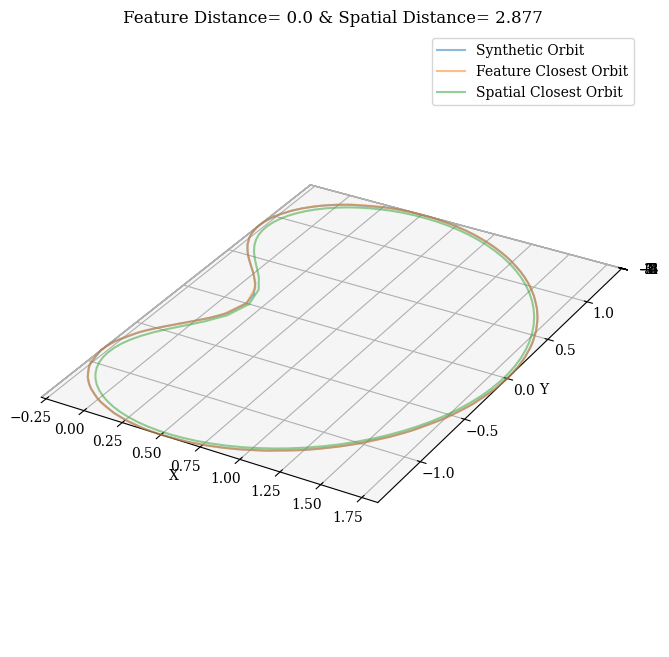

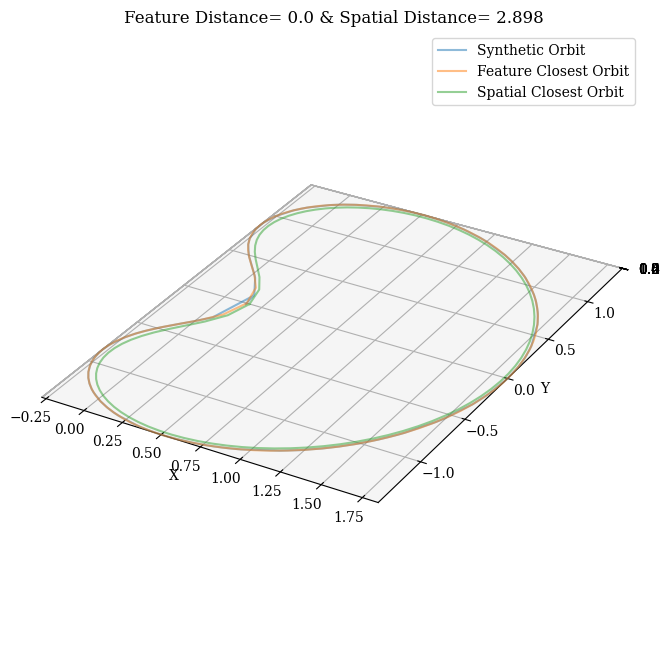

In [ ]:
for i in range(len(refinement_and_closers)):
    title = f"Feature Distance= {discovery_df['feature_distance_from_closest_orbit'].iloc[i].round(3)} & Spatial Distance= {discovery_df['nearest_orbit_distance'].iloc[i].round(3)}"
    visualize_static_orbits(refinement_and_closers[i,:,1:,:], title=title,
                            orbit_names=['Synthetic Orbit', 'Feature Closest Orbit', 'Spatial Closest Orbit'], equal_aspect=True)